Two-stage training was performed using pretrained ResNet50 model weights on the CIFAR-10 dataset. The primary objective was to achieve the highest F1 score.  
Author: Jamoliddin Uraimov  
Date: April 17, 2025

#### Key Features of the CIFAR-10 Training Code:

Two-Stage Training: Trains the final layer first (frozen pretrained layers), then fine-tunes all layers for better accuracy.
Pretrained ResNet50: Uses pretrained ResNet50 model for efficient feature extraction.
CIFAR-10 Dataset: Processes CIFAR-10 with data augmentation (random crop, flip) and normalization.
PyTorch Framework: Leverages PyTorch for model training, optimization, and evaluation.
Metrics: Tracks loss, accuracy, and F1 score; visualizes with confusion matrix and plots.
Tools Used: PyTorch, torchvision, NumPy, Matplotlib, Seaborn, scikit-learn, tqdm.


#### Training Parameters:

Epochs: 100 total (Stage 1: 20 epochs for final layer; Stage 2: 80 epochs for fine-tuning).
Batch Size: 256 for all data loaders (train, validation, test).
Learning Rates:
Stage 1: 0.001 (final layer training).
Stage 2: 0.0001 (fine-tuning all layers).

In [1]:
# Import necessary libraries for data handling, model training, and evaluation
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms, models
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import seaborn as sns
from tqdm.notebook import tqdm
import random
import time
from PIL import Image



In [2]:
# Load and preprocess CIFAR-10 dataset, split into train/validation, and create data loaders
def prepare_data(batch_size=256, train_val_split=0.8):
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
    
    num_train = len(train_dataset)
    indices = list(range(num_train))
    random.shuffle(indices)
    split = int(train_val_split * num_train)
    train_idx, valid_idx = indices[:split], indices[split:]
    
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
    valid_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    return train_loader, valid_loader, test_loader, classes



In [3]:
# Initialize pre-trained model, freeze layers except the final one, and move to device
def setup_model(model_name='resnet50'):
    if model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 10)
    else:
        raise ValueError(f"Unsupported model: {model_name}")
    
    for param in model.parameters():
        param.requires_grad = False
    model.fc.weight.requires_grad = True
    model.fc.bias.requires_grad = True
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    return model, device



In [4]:
# Modelni o'qitish
def train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, device, num_epochs=100):
    """
    Modelni o'qitish
    """
    best_f1 = 0.0
    best_model_wts = model.state_dict()
    
    # O'qitish jarayonini kuzatish uchun ma'lumotlarni saqlash
    history = {
        'train_loss': [],
        'train_acc': [],
        'train_f1': [],
        'val_loss': [],
        'val_acc': [],
        'val_f1': []
    }
    
    for epoch in range(num_epochs):
        start_time = time.time()
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Har bir epochda training va validation
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Training mode
                dataloader = train_loader
            else:
                model.eval()   # Evaluation mode
                dataloader = valid_loader
            
            running_loss = 0.0
            all_preds = []
            all_labels = []
            
            # Progress bar
            with tqdm(dataloader, unit="batch") as tepoch:
                for inputs, labels in tepoch:
                    tepoch.set_description(f"{phase.capitalize()}")
                    
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    # Gradiyentlarni nolga qaytarish
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Training bo'lsa backward pass
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistikani yangilash
                    running_loss += loss.item() * inputs.size(0)
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
            
            # Epoch uchun loss hisoblab chiqish
            epoch_loss = running_loss / len(dataloader.sampler)
            epoch_acc = np.mean(np.array(all_preds) == np.array(all_labels))
            epoch_f1 = f1_score(all_labels, all_preds, average='weighted')
            
            # Natijalarni saqlash
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc)
                history['train_f1'].append(epoch_f1)
                if scheduler is not None:
                    scheduler.step()
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc)
                history['val_f1'].append(epoch_f1)
                
                # Eng yaxshi modelni saqlash
                if epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    best_model_wts = model.state_dict()
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}')
        
        time_elapsed = time.time() - start_time
        print(f'Epoch complete in {time_elapsed:.0f}s')
        print()
    
    # Eng yaxshi modelni qaytarish
    model.load_state_dict(best_model_wts)
    print(f'Best val F1: {best_f1:.4f}')
    return model, history

In [5]:
# Evaluate the model on the test set, compute metrics, and visualize the confusion matrix
def evaluate_model(model, test_loader, criterion, device, classes):
    model.eval()
    test_loss, all_preds, all_labels = 0.0, [], []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item() * inputs.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss /= len(test_loader.dataset)
    test_acc = np.mean(np.array(all_preds) == np.array(all_labels))
    test_f1 = f1_score(all_labels, all_preds, average='weighted')
    
    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f} F1: {test_f1:.4f}')
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))
    
    return test_loss, test_acc, test_f1



In [6]:
# Plot training and validation loss, accuracy, and F1 score over epochs
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(history['train_f1'], label='Train F1')
    plt.plot(history['val_f1'], label='Val F1')
    plt.title('F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    
    plt.tight_layout()
    plt.show()



In [7]:
# Display sample images from the test set with their labels
def show_sample_images(test_loader, classes, num_images=25):
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    
    plt.figure(figsize=(10, 10))
    for i in range(min(num_images, len(images))):
        plt.subplot(5, 5, i + 1)
        img = images[i].permute(1, 2, 0).numpy()
        img = img * np.array([0.2023, 0.1994, 0.2010]) + np.array([0.4914, 0.4822, 0.4465])
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(classes[labels[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()



In [8]:
# Load a trained model and predict the class of a single image
def load_and_predict(image_path, model_path, model_name, classes):
    model, device = setup_model(model_name)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(image)
        probabilities = torch.softmax(outputs, dim=1)[0]
        _, predicted = torch.max(outputs, 1)
    
    predicted_class = classes[predicted.item()]
    top5 = torch.topk(probabilities, 5)
    top5_predictions = {classes[idx]: prob.item() for idx, prob in zip(top5.indices, top5.values)}
    
    plt.imshow(Image.open(image_path))
    plt.title(f'Predicted: {predicted_class}')
    plt.axis('off')
    plt.show()
    
    return predicted_class, top5_predictions



Files already downloaded and verified
Files already downloaded and verified
Stage 1: Training final layer
Epoch 1/20
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 1.7983 Acc: 0.3751 F1: 0.3735


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 1.6646 Acc: 0.4227 F1: 0.4125
Epoch complete in 16s

Epoch 2/20
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 1.6342 Acc: 0.4379 F1: 0.4364


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 1.6127 Acc: 0.4483 F1: 0.4468
Epoch complete in 16s

Epoch 3/20
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 1.5867 Acc: 0.4519 F1: 0.4504


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 1.5926 Acc: 0.4482 F1: 0.4431
Epoch complete in 16s

Epoch 4/20
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 1.5586 Acc: 0.4612 F1: 0.4599


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 1.5666 Acc: 0.4588 F1: 0.4534
Epoch complete in 16s

Epoch 5/20
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 1.5455 Acc: 0.4650 F1: 0.4637


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 1.5518 Acc: 0.4735 F1: 0.4708
Epoch complete in 16s

Epoch 6/20
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 1.5024 Acc: 0.4812 F1: 0.4796


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 1.5174 Acc: 0.4736 F1: 0.4710
Epoch complete in 15s

Epoch 7/20
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 1.4934 Acc: 0.4843 F1: 0.4828


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 1.5154 Acc: 0.4806 F1: 0.4788
Epoch complete in 16s

Epoch 8/20
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 1.4843 Acc: 0.4850 F1: 0.4835


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 1.5075 Acc: 0.4761 F1: 0.4745
Epoch complete in 16s

Epoch 9/20
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 1.4807 Acc: 0.4892 F1: 0.4878


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 1.5098 Acc: 0.4817 F1: 0.4809
Epoch complete in 15s

Epoch 10/20
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 1.4835 Acc: 0.4885 F1: 0.4872


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 1.4967 Acc: 0.4842 F1: 0.4822
Epoch complete in 16s

Epoch 11/20
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 1.4842 Acc: 0.4870 F1: 0.4857


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 1.5028 Acc: 0.4787 F1: 0.4778
Epoch complete in 15s

Epoch 12/20
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 1.4726 Acc: 0.4943 F1: 0.4929


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 1.5141 Acc: 0.4770 F1: 0.4760
Epoch complete in 16s

Epoch 13/20
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 1.4731 Acc: 0.4927 F1: 0.4914


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 1.5119 Acc: 0.4771 F1: 0.4758
Epoch complete in 16s

Epoch 14/20
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 1.4741 Acc: 0.4935 F1: 0.4919


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 1.4980 Acc: 0.4856 F1: 0.4838
Epoch complete in 15s

Epoch 15/20
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 1.4797 Acc: 0.4910 F1: 0.4899


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 1.4949 Acc: 0.4806 F1: 0.4793
Epoch complete in 16s

Epoch 16/20
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 1.4753 Acc: 0.4903 F1: 0.4888


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 1.4955 Acc: 0.4820 F1: 0.4807
Epoch complete in 16s

Epoch 17/20
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 1.4759 Acc: 0.4886 F1: 0.4873


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 1.4887 Acc: 0.4824 F1: 0.4808
Epoch complete in 16s

Epoch 18/20
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 1.4763 Acc: 0.4898 F1: 0.4884


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 1.5066 Acc: 0.4808 F1: 0.4797
Epoch complete in 16s

Epoch 19/20
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 1.4754 Acc: 0.4941 F1: 0.4928


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 1.5117 Acc: 0.4789 F1: 0.4775
Epoch complete in 15s

Epoch 20/20
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 1.4773 Acc: 0.4911 F1: 0.4895


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 1.5106 Acc: 0.4763 F1: 0.4750
Epoch complete in 16s

Best val F1: 0.4838

Stage 2: Fine-tuning all layers
Epoch 1/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 1.0519 Acc: 0.6338 F1: 0.6329


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.8227 Acc: 0.7151 F1: 0.7142
Epoch complete in 20s

Epoch 2/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.6977 Acc: 0.7549 F1: 0.7545


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.6759 Acc: 0.7637 F1: 0.7626
Epoch complete in 19s

Epoch 3/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.5758 Acc: 0.7988 F1: 0.7986


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5959 Acc: 0.7905 F1: 0.7901
Epoch complete in 19s

Epoch 4/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.4819 Acc: 0.8316 F1: 0.8314


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5712 Acc: 0.7997 F1: 0.8003
Epoch complete in 19s

Epoch 5/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.4218 Acc: 0.8518 F1: 0.8516


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5393 Acc: 0.8165 F1: 0.8165
Epoch complete in 19s

Epoch 6/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.3716 Acc: 0.8687 F1: 0.8686


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5103 Acc: 0.8280 F1: 0.8280
Epoch complete in 19s

Epoch 7/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.3315 Acc: 0.8842 F1: 0.8842


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5069 Acc: 0.8295 F1: 0.8287
Epoch complete in 19s

Epoch 8/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.2572 Acc: 0.9110 F1: 0.9109


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.4808 Acc: 0.8400 F1: 0.8401
Epoch complete in 19s

Epoch 9/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.2377 Acc: 0.9177 F1: 0.9177


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5008 Acc: 0.8349 F1: 0.8348
Epoch complete in 19s

Epoch 10/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.2219 Acc: 0.9228 F1: 0.9227


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.4961 Acc: 0.8413 F1: 0.8411
Epoch complete in 19s

Epoch 11/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.2115 Acc: 0.9273 F1: 0.9272


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.4970 Acc: 0.8383 F1: 0.8381
Epoch complete in 19s

Epoch 12/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1999 Acc: 0.9296 F1: 0.9295


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.4917 Acc: 0.8465 F1: 0.8459
Epoch complete in 19s

Epoch 13/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1920 Acc: 0.9334 F1: 0.9333


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.4987 Acc: 0.8424 F1: 0.8422
Epoch complete in 19s

Epoch 14/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1813 Acc: 0.9366 F1: 0.9366


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.4941 Acc: 0.8435 F1: 0.8433
Epoch complete in 19s

Epoch 15/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1692 Acc: 0.9422 F1: 0.9421


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.4966 Acc: 0.8423 F1: 0.8417
Epoch complete in 19s

Epoch 16/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1722 Acc: 0.9410 F1: 0.9410


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5122 Acc: 0.8419 F1: 0.8418
Epoch complete in 19s

Epoch 17/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1665 Acc: 0.9435 F1: 0.9434


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5007 Acc: 0.8422 F1: 0.8422
Epoch complete in 19s

Epoch 18/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1702 Acc: 0.9421 F1: 0.9420


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.4953 Acc: 0.8469 F1: 0.8470
Epoch complete in 19s

Epoch 19/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1643 Acc: 0.9432 F1: 0.9431


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5083 Acc: 0.8415 F1: 0.8416
Epoch complete in 19s

Epoch 20/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1670 Acc: 0.9434 F1: 0.9434


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5093 Acc: 0.8425 F1: 0.8422
Epoch complete in 19s

Epoch 21/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1630 Acc: 0.9437 F1: 0.9437


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.4923 Acc: 0.8445 F1: 0.8441
Epoch complete in 19s

Epoch 22/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1631 Acc: 0.9440 F1: 0.9440


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5042 Acc: 0.8428 F1: 0.8430
Epoch complete in 20s

Epoch 23/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1592 Acc: 0.9465 F1: 0.9465


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5004 Acc: 0.8436 F1: 0.8437
Epoch complete in 19s

Epoch 24/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1585 Acc: 0.9451 F1: 0.9451


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5052 Acc: 0.8421 F1: 0.8420
Epoch complete in 19s

Epoch 25/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1635 Acc: 0.9435 F1: 0.9435


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5053 Acc: 0.8434 F1: 0.8433
Epoch complete in 19s

Epoch 26/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1636 Acc: 0.9427 F1: 0.9427


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5074 Acc: 0.8414 F1: 0.8414
Epoch complete in 19s

Epoch 27/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1598 Acc: 0.9457 F1: 0.9457


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5040 Acc: 0.8413 F1: 0.8412
Epoch complete in 19s

Epoch 28/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1627 Acc: 0.9446 F1: 0.9446


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5138 Acc: 0.8408 F1: 0.8409
Epoch complete in 19s

Epoch 29/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1659 Acc: 0.9424 F1: 0.9423


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5089 Acc: 0.8406 F1: 0.8403
Epoch complete in 19s

Epoch 30/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1661 Acc: 0.9425 F1: 0.9425


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5037 Acc: 0.8472 F1: 0.8471
Epoch complete in 19s

Epoch 31/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1595 Acc: 0.9448 F1: 0.9448


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5112 Acc: 0.8445 F1: 0.8440
Epoch complete in 19s

Epoch 32/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1648 Acc: 0.9429 F1: 0.9429


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5220 Acc: 0.8387 F1: 0.8386
Epoch complete in 19s

Epoch 33/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1618 Acc: 0.9442 F1: 0.9442


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5023 Acc: 0.8438 F1: 0.8441
Epoch complete in 19s

Epoch 34/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1614 Acc: 0.9440 F1: 0.9440


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5057 Acc: 0.8431 F1: 0.8432
Epoch complete in 19s

Epoch 35/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1639 Acc: 0.9432 F1: 0.9432


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5192 Acc: 0.8402 F1: 0.8401
Epoch complete in 19s

Epoch 36/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1644 Acc: 0.9426 F1: 0.9426


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5069 Acc: 0.8443 F1: 0.8441
Epoch complete in 19s

Epoch 37/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1609 Acc: 0.9443 F1: 0.9442


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5082 Acc: 0.8410 F1: 0.8411
Epoch complete in 19s

Epoch 38/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1606 Acc: 0.9445 F1: 0.9445


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5001 Acc: 0.8439 F1: 0.8442
Epoch complete in 19s

Epoch 39/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1606 Acc: 0.9452 F1: 0.9452


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5114 Acc: 0.8401 F1: 0.8402
Epoch complete in 19s

Epoch 40/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1631 Acc: 0.9433 F1: 0.9433


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.4973 Acc: 0.8422 F1: 0.8420
Epoch complete in 19s

Epoch 41/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1618 Acc: 0.9433 F1: 0.9433


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5019 Acc: 0.8422 F1: 0.8422
Epoch complete in 19s

Epoch 42/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1616 Acc: 0.9454 F1: 0.9454


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.4973 Acc: 0.8427 F1: 0.8429
Epoch complete in 19s

Epoch 43/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1628 Acc: 0.9438 F1: 0.9438


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5005 Acc: 0.8411 F1: 0.8408
Epoch complete in 19s

Epoch 44/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1647 Acc: 0.9429 F1: 0.9428


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.4974 Acc: 0.8434 F1: 0.8432
Epoch complete in 19s

Epoch 45/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1600 Acc: 0.9434 F1: 0.9434


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5179 Acc: 0.8405 F1: 0.8405
Epoch complete in 19s

Epoch 46/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1634 Acc: 0.9425 F1: 0.9425


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5079 Acc: 0.8387 F1: 0.8388
Epoch complete in 19s

Epoch 47/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1656 Acc: 0.9433 F1: 0.9433


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5017 Acc: 0.8448 F1: 0.8447
Epoch complete in 19s

Epoch 48/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1616 Acc: 0.9445 F1: 0.9445


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.4973 Acc: 0.8458 F1: 0.8456
Epoch complete in 19s

Epoch 49/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1602 Acc: 0.9452 F1: 0.9452


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5044 Acc: 0.8446 F1: 0.8446
Epoch complete in 19s

Epoch 50/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1625 Acc: 0.9429 F1: 0.9429


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5093 Acc: 0.8404 F1: 0.8401
Epoch complete in 19s

Epoch 51/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1632 Acc: 0.9432 F1: 0.9432


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5101 Acc: 0.8378 F1: 0.8380
Epoch complete in 19s

Epoch 52/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1613 Acc: 0.9444 F1: 0.9444


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5095 Acc: 0.8425 F1: 0.8421
Epoch complete in 19s

Epoch 53/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1672 Acc: 0.9429 F1: 0.9429


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5095 Acc: 0.8439 F1: 0.8436
Epoch complete in 19s

Epoch 54/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1637 Acc: 0.9439 F1: 0.9439


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5118 Acc: 0.8410 F1: 0.8408
Epoch complete in 19s

Epoch 55/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1642 Acc: 0.9433 F1: 0.9433


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5073 Acc: 0.8452 F1: 0.8453
Epoch complete in 20s

Epoch 56/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1587 Acc: 0.9461 F1: 0.9461


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5066 Acc: 0.8424 F1: 0.8421
Epoch complete in 19s

Epoch 57/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1640 Acc: 0.9428 F1: 0.9428


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5147 Acc: 0.8428 F1: 0.8431
Epoch complete in 19s

Epoch 58/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1586 Acc: 0.9449 F1: 0.9449


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5012 Acc: 0.8425 F1: 0.8424
Epoch complete in 19s

Epoch 59/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1647 Acc: 0.9442 F1: 0.9441


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5157 Acc: 0.8409 F1: 0.8407
Epoch complete in 19s

Epoch 60/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1648 Acc: 0.9427 F1: 0.9427


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5069 Acc: 0.8424 F1: 0.8425
Epoch complete in 19s

Epoch 61/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1592 Acc: 0.9459 F1: 0.9459


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5047 Acc: 0.8458 F1: 0.8458
Epoch complete in 19s

Epoch 62/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1635 Acc: 0.9435 F1: 0.9435


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.4921 Acc: 0.8446 F1: 0.8444
Epoch complete in 19s

Epoch 63/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1625 Acc: 0.9444 F1: 0.9443


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5065 Acc: 0.8412 F1: 0.8413
Epoch complete in 19s

Epoch 64/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1606 Acc: 0.9452 F1: 0.9452


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5123 Acc: 0.8410 F1: 0.8408
Epoch complete in 19s

Epoch 65/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1598 Acc: 0.9458 F1: 0.9458


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5077 Acc: 0.8418 F1: 0.8420
Epoch complete in 19s

Epoch 66/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1639 Acc: 0.9429 F1: 0.9428


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5105 Acc: 0.8436 F1: 0.8438
Epoch complete in 19s

Epoch 67/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1636 Acc: 0.9437 F1: 0.9437


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5063 Acc: 0.8406 F1: 0.8406
Epoch complete in 19s

Epoch 68/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1591 Acc: 0.9455 F1: 0.9455


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5095 Acc: 0.8437 F1: 0.8436
Epoch complete in 19s

Epoch 69/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1630 Acc: 0.9432 F1: 0.9432


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5014 Acc: 0.8439 F1: 0.8440
Epoch complete in 19s

Epoch 70/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1609 Acc: 0.9447 F1: 0.9446


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5094 Acc: 0.8415 F1: 0.8415
Epoch complete in 19s

Epoch 71/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1623 Acc: 0.9436 F1: 0.9436


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5111 Acc: 0.8410 F1: 0.8411
Epoch complete in 19s

Epoch 72/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1614 Acc: 0.9440 F1: 0.9440


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.4997 Acc: 0.8430 F1: 0.8431
Epoch complete in 19s

Epoch 73/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1602 Acc: 0.9427 F1: 0.9427


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5036 Acc: 0.8424 F1: 0.8423
Epoch complete in 19s

Epoch 74/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1626 Acc: 0.9441 F1: 0.9441


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5220 Acc: 0.8386 F1: 0.8386
Epoch complete in 19s

Epoch 75/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1636 Acc: 0.9432 F1: 0.9432


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5051 Acc: 0.8444 F1: 0.8442
Epoch complete in 19s

Epoch 76/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1669 Acc: 0.9428 F1: 0.9428


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5190 Acc: 0.8391 F1: 0.8390
Epoch complete in 19s

Epoch 77/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1608 Acc: 0.9443 F1: 0.9442


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5074 Acc: 0.8423 F1: 0.8421
Epoch complete in 19s

Epoch 78/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1596 Acc: 0.9449 F1: 0.9449


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5113 Acc: 0.8386 F1: 0.8386
Epoch complete in 19s

Epoch 79/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1636 Acc: 0.9439 F1: 0.9439


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5138 Acc: 0.8400 F1: 0.8399
Epoch complete in 19s

Epoch 80/80
----------


  0%|          | 0/157 [00:00<?, ?batch/s]

train Loss: 0.1602 Acc: 0.9441 F1: 0.9441


  0%|          | 0/40 [00:00<?, ?batch/s]

val Loss: 0.5021 Acc: 0.8429 F1: 0.8430
Epoch complete in 19s

Best val F1: 0.8471


  0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 0.4804 Acc: 0.8545 F1: 0.8545


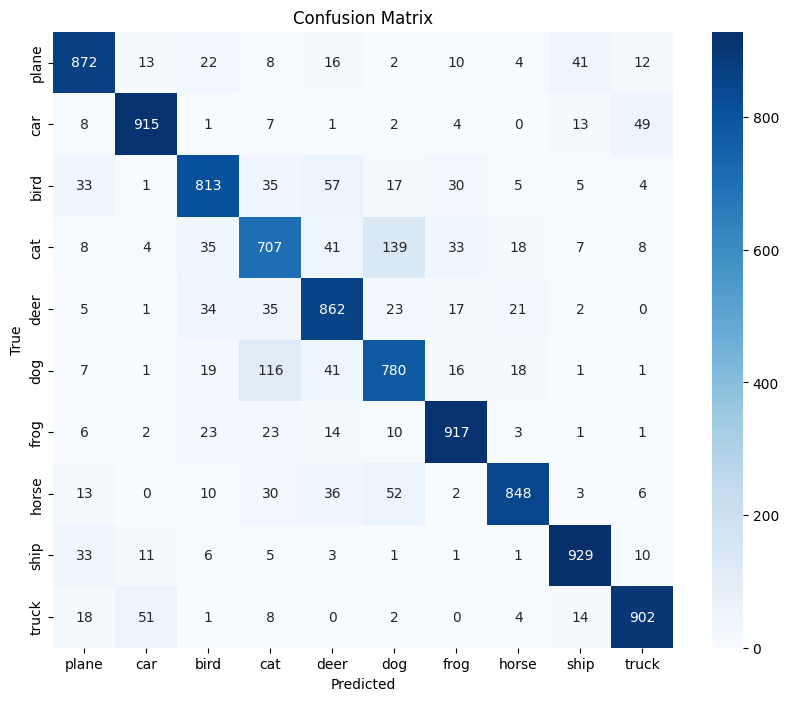


Classification Report:
              precision    recall  f1-score   support

       plane       0.87      0.87      0.87      1000
         car       0.92      0.92      0.92      1000
        bird       0.84      0.81      0.83      1000
         cat       0.73      0.71      0.72      1000
        deer       0.80      0.86      0.83      1000
         dog       0.76      0.78      0.77      1000
        frog       0.89      0.92      0.90      1000
       horse       0.92      0.85      0.88      1000
        ship       0.91      0.93      0.92      1000
       truck       0.91      0.90      0.91      1000

    accuracy                           0.85     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000



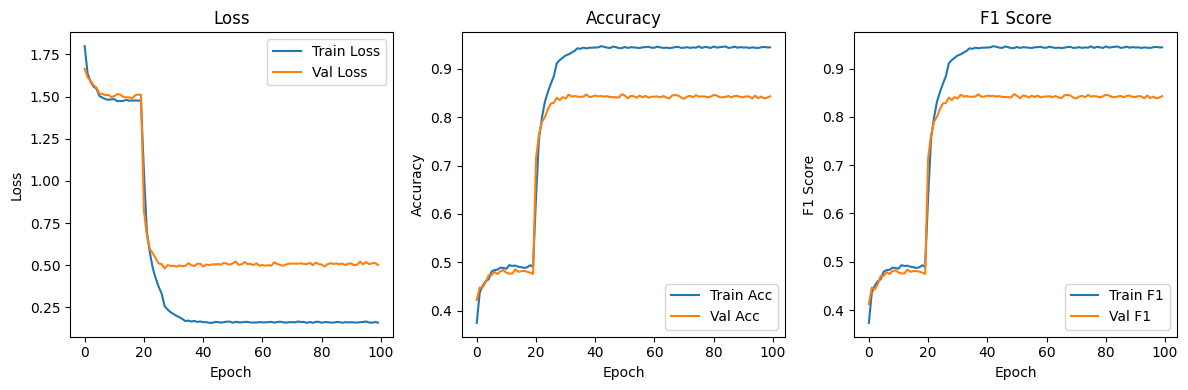

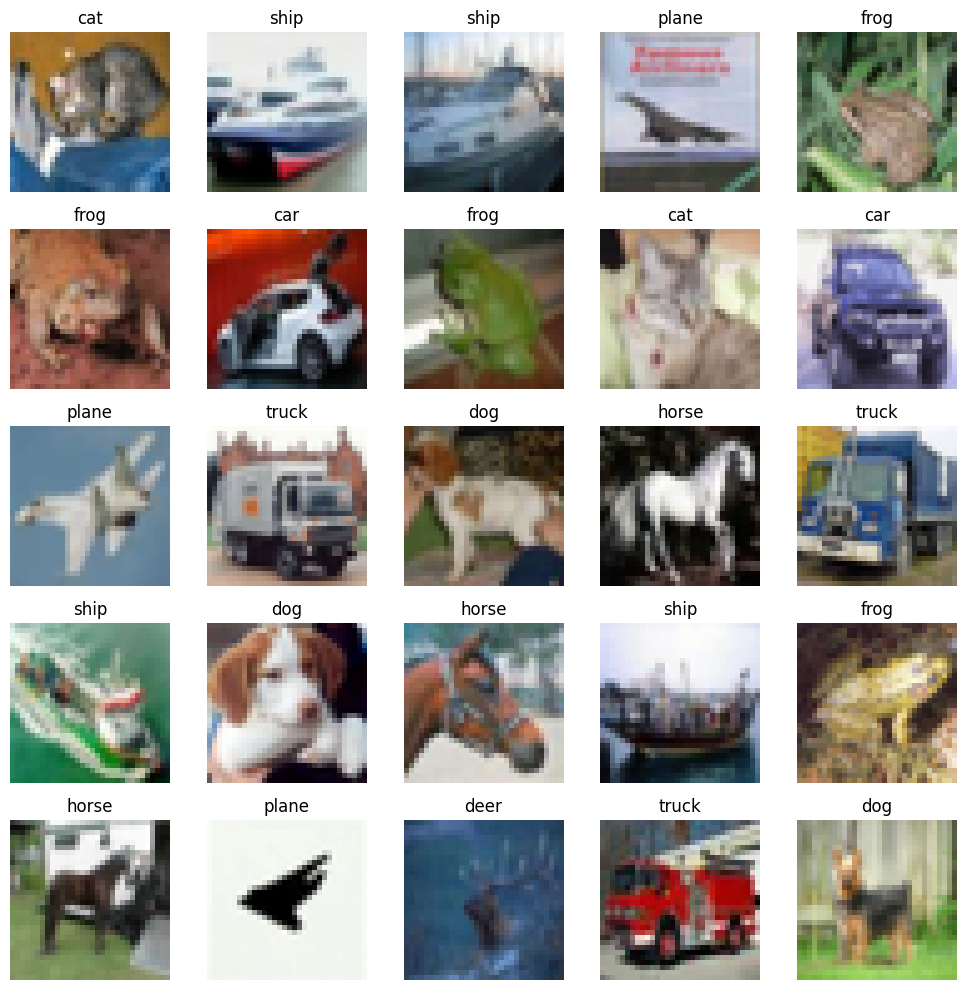

In [10]:
# Main execution with two-stage training

# Train the model in two stages, save models, evaluate on test set, and visualize results


train_loader, valid_loader, test_loader, classes = prepare_data()
model, device = setup_model('resnet50')
criterion = nn.CrossEntropyLoss()

# Stage 1: Train only the final layer
print("Stage 1: Training final layer")
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
model, history_fc = train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, device, num_epochs=20)
torch.save(model.state_dict(), 'stage1_cifar10_model.pth')

# Stage 2: Unfreeze all layers and fine-tune
print("\nStage 2: Fine-tuning all layers")
for param in model.parameters():
    param.requires_grad = True
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model, history_ft = train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, device, num_epochs=80)
torch.save(model.state_dict(), 'best_cifar10_model.pth')

# Combine histories
history = {
    'train_loss': history_fc['train_loss'] + history_ft['train_loss'],
    'train_acc': history_fc['train_acc'] + history_ft['train_acc'],
    'train_f1': history_fc['train_f1'] + history_ft['train_f1'],
    'val_loss': history_fc['val_loss'] + history_ft['val_loss'],
    'val_acc': history_fc['val_acc'] + history_ft['val_acc'],
    'val_f1': history_fc['val_f1'] + history_ft['val_f1']
}

evaluate_model(model, test_loader, criterion, device, classes)
plot_training_history(history)
show_sample_images(test_loader, classes)



Two-stage training is effective because:

1. **Stage 1**: Trains only the final layer to quickly adapt pretrained features to the new dataset, preserving general knowledge.
2. **Stage 2**: Fine-tunes all layers with a lower learning rate to refine features, improving accuracy without overfitting.

This balances speed and precision.

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_230608/2864540625.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more deta

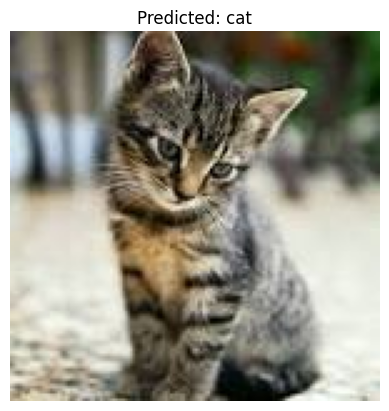

Predicted: cat
Top 5 predictions:
cat: 80.11%
dog: 16.69%
deer: 3.06%
frog: 0.13%
bird: 0.01%


In [11]:
# Predict the class of a test image and display top 5 predictions
image_path = 'cat2.jpg'
model_path = 'best_cifar10_model.pth'
predicted_class, top5_predictions = load_and_predict(image_path, model_path, 'resnet50', classes)

print(f"Predicted: {predicted_class}")
print("Top 5 predictions:")
for class_name, prob in top5_predictions.items():
    print(f"{class_name}: {prob*100:.2f}%")



/tmp/ipykernel_230608/2864540625.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


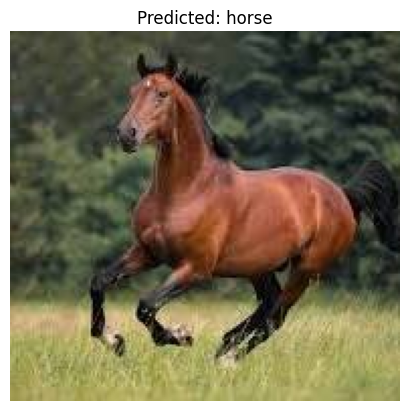

Predicted: horse
Top 5 predictions:
horse: 99.96%
deer: 0.03%
bird: 0.00%
dog: 0.00%
truck: 0.00%


In [12]:
# Predict the class of a test image and display top 5 predictions
image_path = 'ot.jpg'
model_path = 'best_cifar10_model.pth'
predicted_class, top5_predictions = load_and_predict(image_path, model_path, 'resnet50', classes)

print(f"Predicted: {predicted_class}")
print("Top 5 predictions:")
for class_name, prob in top5_predictions.items():
    print(f"{class_name}: {prob*100:.2f}%")

